## Importing the goodies 

In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import time
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from torchvision.transforms import ToTensor
import torchvision
classes = [
           "gastrula",
           "comma",
           "fold",
           "l1"
]

In [0]:
ROOT = "/content/drive/My Drive/kaggle/GSOC/"

## First step - extracting training data from the timelapse
* This involves trimming the timelapse into four parts 
* Then extracting all the frames from the trimmed videos to be converted to numpy arrays

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [0]:
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 32, end_time = 82, target_path = ROOT + "split_labels/gastrula.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 116, end_time = 126, target_path = ROOT + "split_labels/comma.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 140, end_time = 187, target_path = ROOT + "split_labels/fold.mp4")
trim_video(source_path = ROOT + "c_elegans/c_elegans_timelapse.MP4", start_time = 224, end_time = 240, target_path = ROOT + "split_labels/l1.mp4")



[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 32.00 -t 50.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/gastrula.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 116.00 -t 10.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/comma.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 140.00 -t 47.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/fold.mp4
... command successful.

[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/drive/My Drive/kaggle/GSOC/c_elegans/c_elegans_timelapse.MP4 -ss 224.00 -t 16.00 -vcodec copy -acodec copy /content/drive/My Drive/kaggle/GSOC/split_labels/l1.mp4
... command successful.


In [0]:
def videos_to_frames(video_path, new_folder_path):
    # os.mkdir(new_folder_path)
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)

In [ ]:
videos_to_frames(ROOT + "split_labels/gastrula.mp4", new_folder_path = ROOT + "frames/gastrula")
videos_to_frames(ROOT + "split_labels/comma.mp4", new_folder_path = ROOT + "frames/comma")
videos_to_frames(ROOT + "split_labels/fold.mp4", new_folder_path = ROOT + "frames/fold")
videos_to_frames(ROOT + "split_labels/l1.mp4", new_folder_path = ROOT + "frames/l1")

## Tar all images and copy to runtime 
* -C means it'll move to the dir first before compressing

In [0]:
!tar -cvf /content/drive/"My Drive"/kaggle/GSOC/train_images.tar.gz -C  /content/drive/"My Drive"/kaggle/GSOC/frames/ .

In [5]:
!cp --verbose /content/drive/"My Drive"/kaggle/GSOC/train_images.tar.gz /content/ 

'/content/drive/My Drive/kaggle/GSOC/train_images.tar.gz' -> '/content/train_images.tar.gz'


In [0]:
!mkdir raw_images
!tar -xvf  /content/train_images.tar.gz -C /content/raw_images/

## Generating training data from saved frames
* img_to_arr() takes in the path of an image and returns a numpy array of the image

In [0]:
def  generate_csv(source_folder, subfolders_list, save_path = ROOT + "labels.csv", local_save_path = "/content/labels.csv" ):
    
    final_stack = []

    for subfolder in tqdm(subfolders_list):

        for i in tqdm(os.listdir(source_folder + subfolder)):   # i is the img_name btw
            filename = subfolder + i
            label = float(subfolders_list.index(subfolder))

            # print(filename, label)
            
            final_stack.append([filename, label])
    final_stack = np.array(final_stack)

    np.savetxt(save_path , final_stack, delimiter=",", fmt = "%s")
    np.savetxt( local_save_path , final_stack, delimiter=",", fmt = "%s")

    print("saved --", save_path)
    print (" local save -- " ,local_save_path)

In [ ]:
subfolders_list = [
                   "gastrula/",
                   "comma/",
                   "fold/",
                   "l1/"
                  ]
generate_csv(
    source_folder = ROOT + "frames/",
    subfolders_list = subfolders_list,
    save_path = ROOT + "labels.csv"
    )

generate_csv(
    source_folder = ROOT + "frames_val/",
    subfolders_list = subfolders_list,
    save_path = ROOT + "labels_val.csv",
    local_save_path = "/content/labels_val.csv"
    )

In [22]:
df = pd.read_csv(ROOT + "labels.csv")
X = df[df.columns[0]].values.reshape(-1,1)
y = df[df.columns[1]].values
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(X, y)


x_vals  = np.array(x_resampled.reshape(1,-1)[0])
y_vals = np.array(y_resampled)

new_list = []
for i in range(len(x_vals)):
    new_list.append([  x_vals[i], y_vals[i] ])
new_df = pd.DataFrame(new_list)

balanced_labels = new_df.values
np.savetxt(ROOT + 'balanced_labels.csv', balanced_labels, delimiter=',', fmt = "%s")
np.savetxt( '/content/balanced_labels.csv', balanced_labels, delimiter=',', fmt = "%s")


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Visualising the distributions before and after balancing 

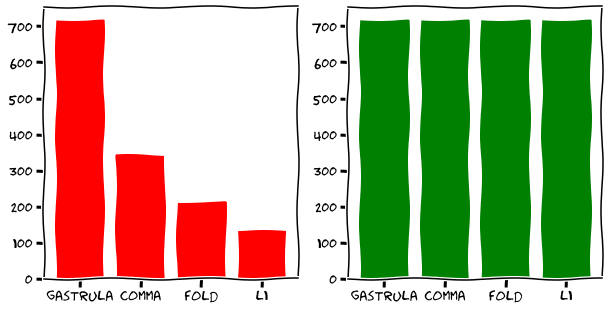

In [23]:
with plt.xkcd():
    fif, ax = plt.subplots(1,2, figsize = (10,5))
    ax[0].bar( classes, df[df.columns[1]].value_counts().values , width = 0.8 , color = "r")
    ax[1].bar(classes, new_df[new_df.columns[1]].value_counts().values, color = "g")
    fif.show()

## Custom class to load up the images for the CNN

In [0]:
def img_to_arr(im_path):
    # print(im_path)
    img = cv2.imread(im_path, 0)
    
    return img

class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_folder_path , csv_file_path , transform = None):

        self.transform = transform

        print("Loading CSV from:  ", csv_file_path)
        print("Loading images from:  ", image_folder_path)

        self.labels = pd.read_csv(csv_file_path, header= None)
        self.label = []
        self.img = []

        for i in tqdm(self.labels.values):
            filename = i[0]
            label_y = float(i[1])
            full_path = image_folder_path + filename
            image_np_array = img_to_arr(full_path)

            self.label.append(label_y)
            self.img.append(image_np_array)

        self.label = np.array(self.label)
        self.img = np.array(self.img)
    def __getitem__(self, item):
            label, img = self.label[item], self.img[item]
            if self.transform is not None:
                img = self.transform(img)
            return img, torch.tensor([label])

    def __len__(self):
        return len(self.label)


## Using the `MyDataset()` class to load up training data of both the sizes

In [ ]:
train_set = MyDataset(
                        image_folder_path = "/content/raw_images/", 
                        csv_file_path = "/content/balanced_labels.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90,120),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

val_set = MyDataset(
                        image_folder_path = ROOT + "frames_val/", 
                        csv_file_path = "/content/labels_val.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90,120),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

train_set_big = MyDataset(
                        image_folder_path = "/content/raw_images/", 
                        csv_file_path = "/content/balanced_labels.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90*2,120*2),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

val_set_big = MyDataset(
                        image_folder_path = ROOT + "frames_val/", 
                        csv_file_path = "/content/labels_val.csv",
                        transform = transforms.Compose([          
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((90*2,120*2),interpolation=Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 15, translate= (0.01, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor()
                                                    ])
)

In [27]:
train_batch_size = 170
val_batch_size = 6

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True)
train_loader_big = DataLoader(train_set_big, batch_size=train_batch_size, shuffle = True)

val_loader = DataLoader(val_set, batch_size= val_batch_size , shuffle = True)
val_loader_big = DataLoader(val_set_big, batch_size= val_batch_size , shuffle = True)

print(len(train_loader), len(val_loader))

17 17


## Taking a look at the training data in both the sizes

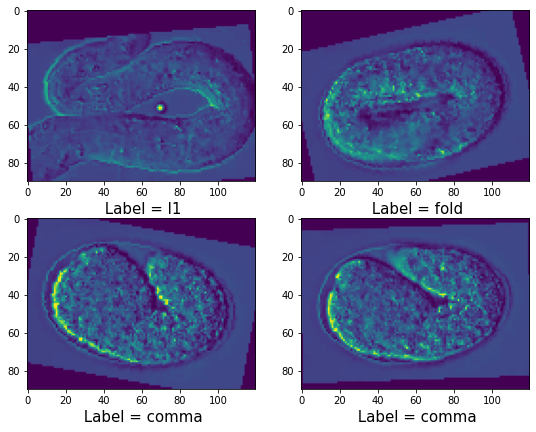

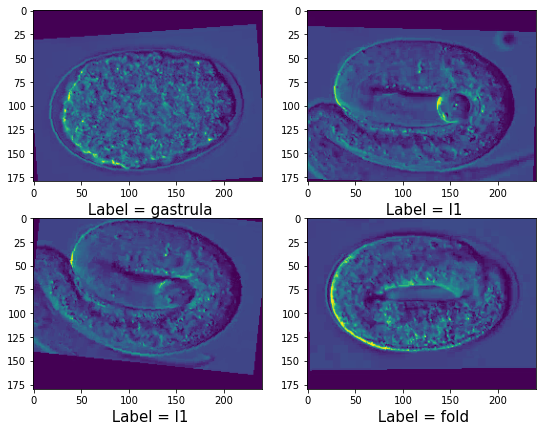

In [0]:
sample = next(iter(train_loader))
image_batch, labels = sample
fig, ax = plt.subplots(2,2, figsize = (9,7))
c = 0
for i in range (2):
    for j in range (2):
    
        image_np = image_batch[c].squeeze(0).squeeze(0).numpy()
        
        ax[i,j].imshow(image_np)
        x =  " Label = " + str(classes[int(labels[c].item())])
        ax[i,j].set_xlabel(x, fontsize= 15)
        c += 1

sample = next(iter(train_loader_big))
image_batch, labels = sample
fig, ax = plt.subplots(2,2, figsize = (9,7))
c = 0
for i in range (2):
    for j in range (2):
    
        image_np = image_batch[c].squeeze(0).squeeze(0).numpy()
        
        ax[i,j].imshow(image_np)
        x =  " Label = " + str(classes[int(labels[c].item())])
        ax[i,j].set_xlabel(x, fontsize= 15)
        c += 1

## Visualising the training metrics 
* and defining `vis_loss_multi_colors()` , which is basically a poor man's  tensorboard



In [0]:

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()

## defining the training loop 
* `StepLR()` decays the learning rate by certain factor gamma after each epoch. It helps prevent random spikes in validation and training loss after the initial few epochs
* `calculate_accuracy_on_validation_set()` works with Dataloader objects.


In [0]:
def calculate_accuracy_on_validation_set(val_loader):
    
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            pred = cellnet(x_val)  # pred
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val.squeeze(-1)))])  ## fix size with squeeze(-1)
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc

def train_step(x, y):
        optimizer.zero_grad()
        pred = cellnet(x)
        y = y.long().squeeze(-1)
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(epochs, train_loader, val_loader):
    start = time.process_time()
    losses = []
    val_losses = []
    times = []
    timed_val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long().squeeze(-1)  ## fix size with squeeze(-1)
                yhat =cellnet(x_val)

              
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
                
                timed_val_losses.append(val_loss.item())
                times.append(time.process_time()- start)
        cellnet.train()
        
        
        for x_batch, y_batch in tqdm(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses

## Defining the NN architecture
* Larger pool size for max pooling was used because the classifying factors spanned over a relatively larger area, and not in the fine details


In [34]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(5,5)

        self.pool2 = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 3)
        
        self.fc1 = nn.Linear(150, 110)
        self.fc2 = nn.Linear(110, 100)
        self.fc3 = nn.Linear(100, 4)

    def forward(self, x):
        x = (self.pool(F.relu(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))      ## removed relu
        return x

cellnet = Net()
print(cellnet)

optimizer = optim.Adam(cellnet.parameters(), lr = 0.0009) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=150, out_features=110, bias=True)
  (fc2): Linear(in_features=110, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
)


## First, we train the CNN on smaller images for 4 epochs
* smaller images means faster forward passes and overall a faster training time
* they'll help give the CNN a good start when it has to train on the larger images

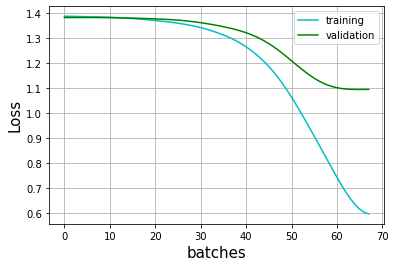

Time elapsed =  36.67074593999999  seconds


In [35]:
losses, val_losses = train( 4, train_loader, val_loader)

## After 4 epochs on the smaller images, we get an accuracy of about 91%


In [0]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(val_loader), "%")

Accuracy =  91.0 %


## Freezing all the layers except for the first 2  linear layers
* The shape of the first linear layer was changed to accomodate the forward pass of a larger image (hence a larger tensor)
* The shape of the second layer was changed to prevent an overly abrupt change in size

In [0]:
cellnet.conv1.weight.requires_grad = False
cellnet.conv1.bias.requires_grad = False

cellnet.conv2.weight.requires_grad = False
cellnet.conv2.bias.requires_grad = False

cellnet.conv3.weight.requires_grad = False
cellnet.conv3.bias.requires_grad = False

cellnet.fc1 = nn.Linear(1170, 500)  ## reshaping 2 linear layers to accomodate forward pass
cellnet.fc2 = nn.Linear(500, 100)

cellnet.fc3.weight.requires_grad = False
cellnet.fc3.bias.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, cellnet.parameters()), lr=0.0008)


## Training just the new larger linear layers 
* All the other layers are frozen, so the training takes considerably less time.
* Backpropagation only occurs only on the 2 larger linear layers

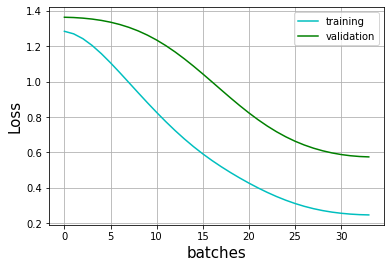

Time elapsed =  29.568404539999847  seconds


In [0]:
losses_2, val_losses_2 = train(2, train_loader_big, val_loader_big)
losses.extend(losses_2)
val_losses.extend(val_losses_2)

## Accuracy on the test set jumps from 91% to 95% in the next 2 epochs
* Achieving 95% accuracy on ¶the large images alone would've take more epochs and hence more time to train.

* The spike that we see in the plot above is because the the 2 new linear layers were untrained, but they got trained pretty fast ( with 2 epochs)

In [0]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(val_loader_big), "%")

Accuracy =  95.0 %


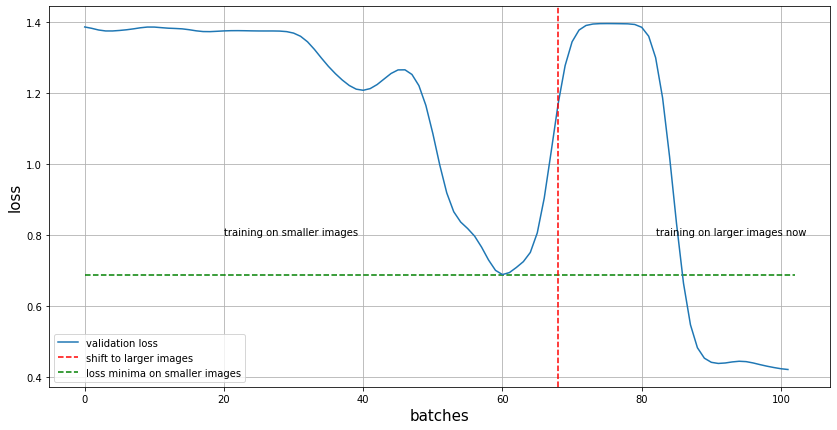

In [0]:
ysmoothed = gaussian_filter1d(val_losses, sigma=2)
plt.figure(figsize=(14,7))
plt.plot(ysmoothed, label = "validation loss")
plt.hlines(min(ysmoothed[:68]), 0, len(val_losses), linestyle = "--", colors= "green", label = "loss minima on smaller images")
plt.axvline(x=68, color = "red", linestyle = "--", label = "shift to larger images")
plt.text(82, 0.8, r'training on larger images now', fontsize=10)
plt.text(20, 0.8, r'training on smaller images', fontsize=10)
plt.xlabel("batches", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.grid()
plt.legend()
plt.show()

## Now let's see how long it takes for the same architecture to reach high accuracies without transfer learning
* all the weights would reset and the CNN would now train only on the larger images


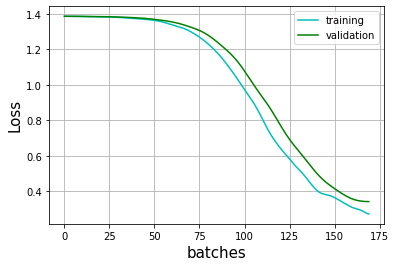

Time elapsed =  449.1401728369997  seconds


In [0]:

cellnet.fc1 = nn.Linear(1170, 500)  ## reshaping 2 linear layers to accomodate forward pass
cellnet.fc2 = nn.Linear(500, 100)
losses_big, val_losses_big = train(10, train_loader_big, train_loader_big)


## It took the CNN about 65 seconds to reach 95% accuracy with transfer learning, while it took 450 seconds to reach 92% without transfer learning 
* with transfer learning with image resizing it took about one fourth of the time to reach a higher accuracy

In [0]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(train_loader_big), "%")

Accuracy =  92.61838440111421 %
